# Préparation des données

## Import et data augmentations

In [1]:
from  src.dataloader import *
from src.metrics import *
from src.resnet18 import *
 
import pandas as pd
import numpy as np

from src.confusion_matrix import make_confusion_matrix
from sklearn.metrics import confusion_matrix

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn


import tensorflow as tf
import keras
import keras.layers as layers
from keras.losses import BinaryCrossentropy


In [2]:
tf.random.set_seed(42)

In [3]:
label_attribution=LabelAttribution(path_image_google="C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/", 
                                   path_mask_google='C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/mask/',
                                   path_metadata='C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/metadata.csv',
                                   colonne_identifiant='identifiant',
                                   path_export_train_test="C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps",
                                   path_image_ign='C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/ign/img',
                                   path_mask_ign='C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/ign/mask/',
                                   use_img_google=True,
                                   use_img_ign=False
                                    )

In [4]:
label_attribution.run()

In [5]:
path_train="C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps/train_data.csv"
path_test="C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps/test_data.csv"

transformed_train_dataset  = CustomImageDataset(path_train,"C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/", transform=transforms.Compose([
                                               transforms.Resize(224),
                                               transforms.ColorJitter(brightness=(0.6, 1.4), contrast=(0.6, 1.4), saturation=(0.6, 1.4), hue=(-0.5, 0.5)),
                                               transforms.RandomCrop(160),
                                               transforms.RandomHorizontalFlip(p=0.5),
                                               transforms.RandomVerticalFlip(p=0.5),
                                               transforms.RandomRotation(degrees = (0,180)),
                                               transforms.Resize(224),
                                               transforms.ToTensor(),
                                               #transforms.Normalize(mean = [0.2969593107700348, 0.29610514640808105, 0.29613879323005676],
                                                                    #std= [0.19015252590179443, 0.18941254913806915, 0.18982695043087006])

                                           ]))

#On resize et normalise uniquement sur le test
transformed_test_dataset = CustomImageDataset(path_test,"C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/",
                                            transform=transforms.Compose([
                                               transforms.Resize(224),
                                               transforms.ToTensor(),
                                               #transforms.Normalize(mean = [0.3499923348426819, 0.3576664924621582, 0.3081061840057373],
                                                                    #std= [0.16761955618858337, 0.14885342121124268, 0.1473139077425003])
                                           ]))

In [6]:
print("Nombre d'images dans le train: {}".format(transformed_train_dataset.__len__()))
print("Nombre d'images dans le test: {}".format(transformed_test_dataset.__len__()))

Nombre d'images dans le train: 23045
Nombre d'images dans le test: 5762


In [7]:
train_dataloader = DataLoader(transformed_train_dataset, batch_size=23045, shuffle=True)
test_dataloader = DataLoader(transformed_test_dataset, batch_size=5762, shuffle=True)

In [9]:
mean_train, std_train = mean_std(train_dataloader)
print("Moyenne par channel: {}".format(mean_train.tolist()))
print("Ecart-type par channel: {}".format(std_train.tolist()))

Moyenne par channel: [0.29619696736335754, 0.2954482138156891, 0.2950427234172821]
Ecart-type par channel: [0.21924977004528046, 0.21851609647274017, 0.2186581790447235]


In [8]:
mean_test, std_test = mean_std(test_dataloader)
print("Moyenne par channel: {}".format(mean_test.tolist()))
print("Ecart-type par channel: {}".format(std_test.tolist()))

Moyenne par channel: [0.34992772340774536, 0.35760578513145447, 0.3080298900604248]
Ecart-type par channel: [0.2013908326625824, 0.18425437808036804, 0.1794954240322113]


In [10]:
normalized_train_dataset  = CustomImageDataset(path_train,"C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/", transform=transforms.Compose([
                                               transforms.Resize(28),
                                               transforms.ColorJitter(brightness=(0.6, 1.4), contrast=(0.6, 1.4), saturation=(0.6, 1.4), hue=(-0.5, 0.5)),
                                               transforms.RandomCrop(20),
                                               transforms.RandomHorizontalFlip(p=0.5),
                                               transforms.RandomVerticalFlip(p=0.5),
                                               transforms.RandomRotation(degrees = (0,180)),
                                               transforms.Resize(28),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean = [0.29619696736335754, 0.2954482138156891, 0.2950427234172821],
                                                                    std= [0.21924977004528046, 0.21851609647274017, 0.2186581790447235]), 

                                           ]))


normalize_test_dataset = CustomImageDataset(path_test,"C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/",
                                            transform=transforms.Compose([
                                               transforms.Resize(28),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean = [0.34992772340774536, 0.35760578513145447, 0.3080298900604248],
                                                                    std= [0.2013908326625824, 0.18425437808036804, 0.1794954240322113]), 
                                           ]))
train_dataloader_augmente = DataLoader(normalized_train_dataset, batch_size=23045, shuffle=True)
test_dataloader_augmente = DataLoader(normalize_test_dataset, batch_size=5762, shuffle=True)

In [7]:
X_train, Y_train=next(iter(train_dataloader))
X_test, Y_test=next(iter(test_dataloader))

X_train_permute=X_train.permute(0, 2, 3,1)
X_test_permute=X_test.permute(0, 2, 3,1)

# Lancement du modèle

Les cinq premières métriques représentent les performances de notre algorithme sur l'échantillon d'entrainement, les cinq dernières valeurs (celles précédées du préfixe val_) sont elles calculées sur l'échantillon de test. 

In [8]:
model_init = buildModel()

In [9]:
history=model_init.fit(x = X_train_permute.numpy(), y = Y_train.numpy(),
	validation_data=(X_test_permute.numpy(), Y_test.numpy()),
	batch_size=32,
	epochs=5)

Epoch 1/5
 30/721 [>.............................] - ETA: 4:55:36 - loss: 21.8206 - Accuracy: 0.5177 - recall_m: 0.4840 - precision_m: 0.3247 - f1_m: 0.3630

In [ ]:
recall = history.history['recall_m']
val_recall = history.history['val_recall_m']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(recall) + 1)

plt.plot(epochs, recall, 'b', label="Recall sur l'échantillon d'apprentissage")
plt.plot(epochs, val_recall, 'b', label="Recall sur l'échantillon test", color="red")
plt.title("Recall sur l'échantillon d'apprentissage et l'échantillon test")
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label="Loss sur l'échantillon d'apprentissage")
plt.plot(epochs, val_loss, 'b', label="Loss sur l'échantillon test", color="red")
plt.title("Loss sur l'échantillon d'apprentissage et l'échantillon test")
plt.legend()
plt.show()

In [ ]:
loss, accuracy, recall_m, precision_m, f1_m = model_init.evaluate(X_test_permute.numpy(), Y_test.numpy(), verbose=0)
print("Loss sur l'échantillon test: {}".format(np.round(loss,3)))
print("Accuracy sur l'échantillon test: {}".format(np.round(accuracy,3)))
print("Recall sur l'échantillon test: {}".format(np.round(recall_m,3)))
print("Precision sur l'échantillon test: {}".format(np.round(precision_m,3)))
print("F1-score sur l'échantillon test: {}".format(np.round(f1_m,3)))

Loss sur l'échantillon test: 1.064
Accuracy sur l'échantillon test: 0.438
Recall sur l'échantillon test: 0.706
Precision sur l'échantillon test: 0.48
F1-score sur l'échantillon test: 0.571


In [ ]:
prob_predict = model_init.predict(X_test_permute.numpy())
y_pred = (np.squeeze(prob_predict) > 0.5).astype("int32")

1/1 [==============================] - 38s 38s/step


In [ ]:
unique, counts = np.unique(y_pred, return_counts=True)
res=dict(zip(unique, counts))
print("Nombre d'images prédites avec panneaux: {}".format(res[1]))
print("Nombre d'images prédites sans panneau: {}".format(res[0]))

Nombre d'images prédites avec panneaux: 25
Nombre d'images prédites sans panneau: 7


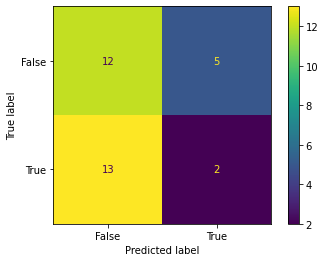

In [ ]:

r = confusion_matrix(Y_test, y_pred)
labels = ["Vrais négatifs","Faux Positifs","Faux négatifs","Vrais positifs"]
categories = ["0", "1"]
make_confusion_matrix(r, 
                      group_names=labels,
                      categories=categories, 
                      )